# Approach 4: Data forecasting with ARIMA model but by adding exogenous variables

In this notebook we are going to try to forecast the player's OBP using an ARIMA model but this time we will add exogenous variables to see if that improves prediction. 


NOTE: Since exog variables have to be provided for future values, we need to shift our data so we can treat past data as future data. I.e., exog is usually seasonal data to say what will happen. We don't know things like xBA, BABIP, etc. in the future, so we can instead roll those values forward and treat them as future observed values. Correct? Not sure but it is an interersting thought. A better approach is probably to use another ML model where we have many predictors to estimate the desired OBP value. Let's give it a shot anyways... 

In [59]:
import numpy as np
import pandas as pd
import pybaseball
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"

import scipy.stats as stats
import statsmodels.api as sm

# Define colors
red     = np.divide((232, 24, 40),255)
blue    = np.divide((0, 45, 114),255)
skyblue = np.divide((86, 180, 233),255)
blue_cb = np.divide((0, 114, 178),255)
green   = np.divide((0, 158, 115),255)
pink    = np.divide((204, 121, 167),255)
orange  = np.divide((230, 159, 0),255)
grey    = (.5, .5, .5) 

## Load data

In [37]:
def add_mlb_id(temp,_players):
    temp["key_mlbam"] = _players.loc[_players.key_fangraphs.isin([temp.playerid]),"key_mlbam"].item()
    return temp

# Useful dicts/lists that will be needed throughout.
mlb_dates = pd.DataFrame({"Year" : [2015, 2016, 2017, 2018, 2019],
                          "Start": pd.to_datetime(['2015-04-05','2016-04-03','2017-04-02','2018-03-29','2019-04-20']),
                          "End"  : pd.to_datetime(['2015-11-01','2016-10-02','2017-11-01','2018-10-28','2019-09-29'])}).set_index("Year")

# Load data as bd -> short for batting data
bd = pd.read_csv("./data/batting.csv")

# Convert and % str to float
cols = [col for col in bd.columns if '%' in col] + ["MarApr_HR/FB"]
for col in cols:
    bd[col] = bd[col].str.rstrip('%').astype('float') / 100.0

# Get data for matching IDs    
_players = pybaseball.playerid_reverse_lookup(bd.playerid.tolist(),key_type='fangraphs')
_players.dropna(subset=["name_last","name_first"],axis=0,inplace=True)

# Get MLB id
bd = bd.apply(lambda temp: add_mlb_id(temp,_players),axis=1)
bd.head()

# Load statcast data
sd = pd.read_pickle("./data/forecasting_data_2015-2019.pkl")

# Get rolling OBP on a seasonal and career basis
sd = sd.groupby(by=["batter","year"]).apply(lambda gdf: gdf.assign(OBP_expanding_year=lambda gdf: gdf['OBP'].expanding().mean()))#.droplevel()
sd = sd.groupby(by=["batter"]).apply(lambda gdf: gdf.assign(OBP_expanding_career=lambda gdf: gdf['OBP'].expanding().mean()))#.droplevel()


# Add additional rolling metrics to add as exogenous variables:
# BABIP
sd = sd.groupby(by=["batter","year"]).apply(lambda gdf: gdf.assign(BABIP_expanding_year=lambda gdf: gdf['BABIP'].expanding().mean()))#.droplevel()
sd = sd.groupby(by=["batter"]).apply(lambda gdf: gdf.assign(BABIP_expanding_career=lambda gdf: gdf['BABIP'].expanding().mean()))#.droplevel()
# SLG
sd = sd.groupby(by=["batter","year"]).apply(lambda gdf: gdf.assign(SLG_expanding_year=lambda gdf: gdf['Slg'].expanding().mean()))#.droplevel()
sd = sd.groupby(by=["batter"]).apply(lambda gdf: gdf.assign(SLG_expanding_career=lambda gdf: gdf['Slg'].expanding().mean()))#.droplevel()
# xBA
sd = sd.groupby(by=["batter","year"]).apply(lambda gdf: gdf.assign(xBA_expanding_year=lambda gdf: gdf['xBA'].expanding().mean()))#.droplevel()
sd = sd.groupby(by=["batter"]).apply(lambda gdf: gdf.assign(xBA_expanding_career=lambda gdf: gdf['xBA'].expanding().mean()))#.droplevel()

# Select 10 random players to view - make sure there are no nans in the names
which_players = bd.loc[bd.Team.isin(["HOU"]),"key_mlbam"]


We need to get all relevant data from each game in order to calculate cumulative metrics.

In [38]:
# Get data from baseball reference
def get_previous_OBP(this_guy,year=2015):
    # Get url for player
    url    = "https://www.baseball-reference.com/players/{}/{}.shtml#batting_standard".format(this_guy.key_bbref.item()[0],this_guy.key_bbref.item())
    # Read table from url
    table = pd.read_html(url)[0]
    # Remove nan rows
    table.dropna(subset=['Tm'],inplace=True)
    # Remove minor league stats
    table = table.loc[~table['Tm'].str.contains('-min'),:].reset_index(drop=True)
    # Get stats
    table = table.loc[table['Year'].isin(list(map(str,list(range(int(table.Year[0]),year+1))))),:]

    OB = (table.H.astype(int).sum() + table.BB.astype(int).sum() + table.HBP.astype(int).sum())
    TA = (table.AB.astype(int).sum() + table.BB.astype(int).sum() + table.HBP.astype(int).sum() + table.SF.astype(int).sum())

    return OB, TA
    

# Get all pitcher data
from pybaseball.lahman import pitching
pitching_data = pitching()
_pitcher = pybaseball.playerid_reverse_lookup(pitching_data.playerID.unique().tolist(),key_type='bbref')

# Get alpha, beta if pitcher or not
def get_params(this_player):
    # Determine if pitcher
    if len(_pitcher.loc[_pitcher.key_mlbam.isin([this_player]),:]):
        fl = './data/OBP_EB_params_pitcher.npy'
    else:
        fl = './data/OBP_EB_params_nonpitcher.npy'

    # load file
    with open(fl, 'rb') as f:
            alpha, beta = np.load(f)
    return alpha, beta

# Add data to dataframe
def eb_estimate_obp_simulated(row,alpha,beta,OB_key, TA_key):
    return (row[OB_key] + alpha) / (row[TA_key] + alpha + beta)

Now we need to apply this to every player so we can use for forecasting. This way of looping through is not the fastest way but it works...

In [39]:
# Empty dataframe for all data
sd2 = pd.DataFrame()

# For each player
for this_player in sd.batter.unique().tolist():
    
    # Get previous data
    this_guy = _players.loc[_players.key_mlbam.isin([this_player]),:]
    if (this_guy.mlb_played_first < 2015).bool():
        OB, TA = get_previous_OBP(this_guy)
    
    # Get prior (alpha, beta)
    alpha, beta = get_params(this_player)

    # pre allocate
    _local = pd.DataFrame()
    # for each year - even if player did not play that year
    for year in mlb_dates.index:
        # Get data for batter and year and set the game date as the index
        temp = sd.loc[(sd.batter==this_player) & (sd.year == year),:].set_index("game_date")
        # Convert to date time
        temp.index = pd.DatetimeIndex(temp.index)
        # Add all dates during season -- this will add nans where no date curently exists
        temp = temp.reindex(pd.date_range(mlb_dates.loc[year,"Start"],mlb_dates.loc[year,"End"]))
        # Add the batter ID across all time
        temp.loc[:,"batter"]  = temp.loc[:,"batter"].fillna(this_player).astype(int)
        # Fill OBP by first filling from back value (i.e., moving --->) then do a backward pass and forward fill (i.e., <----)
        temp.loc[:,"OBP_expanding_year"] = temp.loc[:,"OBP_expanding_year"].ffill().bfill()
        temp.loc[:,"OB_cumulative"] = temp.loc[:,"OB"].fillna(0).cumsum()
        temp.loc[:,"TA_cumulative"] = temp.loc[:,"TA"].fillna(0).cumsum()

        # Fill other values
        temp.loc[:,"SLG_expanding_year"] = temp.loc[:,"SLG_expanding_year"].ffill().bfill()
        temp.loc[:,"xBA_expanding_year"] = temp.loc[:,"xBA_expanding_year"].ffill().bfill()
        temp.loc[:,"BABIP_expanding_year"] = temp.loc[:,"BABIP_expanding_year"].ffill().bfill()

        # EB estimate on year over year average
        temp.loc[:,"OBP_expanding_year_EB"] = temp.apply(lambda row: eb_estimate_obp_simulated(row,alpha, beta,"OB_cumulative","TA_cumulative"),axis=1)
        # Add to outer df
        _local = pd.concat([_local.loc[:,_local.columns != "index"],temp],axis=0)
        # end (for year):

    # Get name and re-add to dataframe as first + last
    name_last, name_first = _players.loc[_players.key_mlbam.isin([this_player]),"name_last"], _players.loc[_players.key_mlbam.isin([this_player]),"name_first"]
    _local.loc[:,"player_name"] = name_first.item().capitalize() + " " + name_last.item().capitalize()
    
    # Fill career OBP using last value
    _local.loc[:,"OBP_expanding_career"] = _local.loc[:,"OBP_expanding_career"].ffill()
    _local.loc[:,"OB_cumulative_career"] = _local.loc[:,"OB"].fillna(0).cumsum()
    _local.loc[:,"TA_cumulative_career"] = _local.loc[:,"TA"].fillna(0).cumsum()

    # Fill additional values for exog
    _local.loc[:,"SLG_expanding_career"] = _local.loc[:,"SLG_expanding_career"].ffill()
    _local.loc[:,"xBA_expanding_career"] = _local.loc[:,"xBA_expanding_career"].ffill()
    _local.loc[:,"BABIP_expanding_career"] = _local.loc[:,"BABIP_expanding_career"].ffill()

    # EB estimate on year over year average
    _local.loc[:,"OBP_expanding_career_EB"] = _local.apply(lambda row: eb_estimate_obp_simulated(row,alpha, beta,"OB_cumulative_career","TA_cumulative_career"),axis=1)

    # Move game date to new column and reset the index as a standard index
    _local = _local.rename_axis('game_date').reset_index()

    # Add to outer dataframe
    sd2 = pd.concat([sd2,_local])

# Reset index
sd2 = sd2.reset_index(drop=True)


Let see what the exogenous variables look like with the endogenous (OBP)

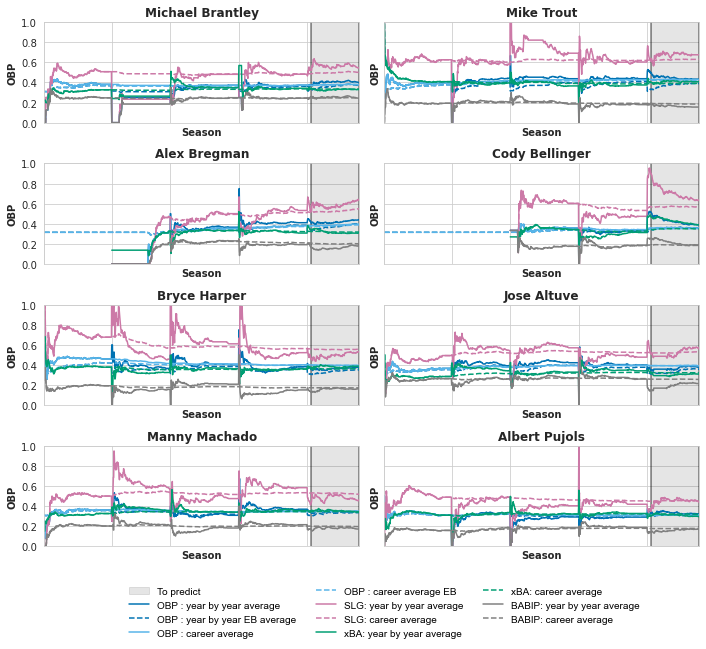

In [85]:
exog_prefix = ["SLG", "xBA","BABIP"]
which_players=["Michael Brantley", "Mike Trout", "Alex Bregman", "Cody Bellinger", "Bryce Harper", "Jose Altuve", "Manny Machado", "Albert Pujols"]

# Make figure
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(int(len(which_players)/2 + 1),2,sharex=True,sharey=True)
    ax = ax.flatten()
    fig.set_size_inches(10,10)

    for (name,thisax) in zip(which_players,ax):
        
        # Get player data
        _local = sd2.loc[sd2.player_name.isin([name]),:].reset_index(drop=True)

        # Get the index location of the start game dates
        xticks1 = _local.loc[_local.game_date.isin(mlb_dates.Start)].index
        
        # Get index location of data window
        fill_win = _local.loc[_local.game_date.isin(pd.date_range('2019-04-30',mlb_dates.loc[2019,"End"]))].index
        

        # Plot data - cumulative OBP year by year and career
        thisax.axvline(x=fill_win[0],color='k',alpha=0.5)
        thisax.axvline(x=fill_win[-1],color='k',alpha=0.5)
        thisax.fill_between(x=fill_win,y1=len(fill_win)*[0],y2=len(fill_win)*[1],color='k',alpha=0.1,label="To predict")
        thisax.plot(_local.index,_local.OBP_expanding_year,color=blue_cb,lw=1.5, label="OBP : year by year average")
        thisax.plot(_local.index,_local.OBP_expanding_year_EB,color=blue_cb,linestyle='--',lw=1.5,label="OBP : year by year EB average")
        thisax.plot(_local.index,_local.OBP_expanding_career,color=skyblue,lw=1.5,label="OBP : career average")
        thisax.plot(_local.index,_local.OBP_expanding_career_EB,color=skyblue,linestyle='--',lw=1.5,label="OBP : career average EB")
        
        for (exog,clr) in zip(exog_prefix,(pink,green,grey)):

            thisax.plot(_local.index,_local[exog + "_expanding_year"],color=clr,lw=1.5,label=exog + ": year by year average")
            thisax.plot(_local.index,_local[exog + "_expanding_career"],color=clr,linestyle='--',lw=1.5,label=exog + ": career average")

        # Clean up
        thisax.set_ylim(0,1)
        thisax.set_xlim(_local.loc[_local.game_date.isin([mlb_dates.loc[2015,"Start"],mlb_dates.loc[2019,"End"]])].index)
        thisax.set_xticks(xticks1)
        thisax.set_xticklabels(list(map(str,mlb_dates.index)))
        thisax.set_xlabel("Season",fontweight="bold")
        thisax.set_ylabel("OBP",fontweight="bold")
        thisax.set_title(_local.player_name.unique()[0],fontweight="bold")

plt.tight_layout()            
ax[-3].legend(ncol=3,loc=8,frameon=False,bbox_to_anchor=(0, -1))
ax[-2].set_visible(False)
ax[-1].set_visible(False)


## Forecasting using an ARIMA model and exogenous variables

Instead of just using past OBP we will add exogenous variables to aid in the forecast.

In [146]:
import pmdarima as pm
import copy

##########################
#                        #
#          TRAIN         #
#                        #
##########################
def train_arima(train,exog):
    # Fit model
    model_fit = pm.auto_arima(train, exogenous=exog, start_p=1, start_q=1, max_p=10, max_q=3, m=12,
                            start_P=0, seasonal=True, d=1, D=1, trace=True,
                            error_action='ignore',  # don't want to know if an order does not work
                            suppress_warnings=True,  # don't want convergence warnings
                            stepwise=True)  # set to stepwise

    return model_fit

##########################
#                        #
#          TEST          #
#                        #
##########################
def test_arima(model,test_data,exog,n_periods,update_with_true=False):
    
    # Max n_periods
    if n_periods > len(test_data):
        n_periods = len(test_data)

    out = pd.DataFrame({"predict": [], "ci_low": [], "ci_high": []})
    
    # If predicting full length of data and with no true updates do it in one step
    if (n_periods == len(test_data)) & (update_with_true == False):
        test_predict, confint = model.predict(n_periods=n_periods,exogenous=exog ,return_conf_int=True)
        out = pd.concat([out,pd.DataFrame({"predict": test_predict, "ci_low": confint[:,0], "ci_high": confint[:,1]})],axis=0)
    # otherwise, use loop to shift along data
    else: 
        # Loop through based on number of iterations
        predict = []
        cnt = 0
        while (cnt+n_periods) < len(test_data):              
                # Make prediction n_periods out
                test_predict, confint = model.predict(n_periods=n_periods,exogenous= exog[cnt:(cnt+n_periods),:],return_conf_int=True)
                # Update model
                if update_with_true:
                    model.update(test_data[cnt:(cnt+n_periods)],X=exog[cnt:(cnt+n_periods),:],maxiter=10)
                else:
                    model.update(test_predict,X=exog[cnt:(cnt+n_periods),:],maxiter=10)
                # Add to dataframe and concat along rows
                out = pd.concat([out,pd.DataFrame({"predict": test_predict, "ci_low": confint[:,0], "ci_high": confint[:,1]})],axis=0)
                # Update count
                cnt += n_periods

    return out.reset_index(drop=True), model

def train_test_arima(player_names,endog_column=[],exog_column=[],n_periods=50,update_with_true=True):
    # Select a few so it doesnt run until eternity
    # which_players = bd.loc[bd.Name.isin(["Bryce Harper"]),"key_mlbam"].tolist() #
    which_players = bd.loc[bd.Name.isin(player_names    ),"key_mlbam"].tolist()

    # For each player
    player_dict = sd2.groupby(by="batter").agg({"player_name": "last"})
    model_dict = pd.DataFrame({"Batter": [name for name in which_players], "Name": [player_dict.loc[name,"player_name"] for name in which_players], "Model": len(which_players)*[0],"Predictions": len(which_players)*[0]})
    allmodels = []
    predictions = []
    for name in which_players:
        # Get player data
        player_data = sd2.loc[sd2.batter.isin([name]),:].reset_index(drop=True)
    
        # Shift exog columns into the future
        for col in exog_column:
                 player_data[col] = player_data[col].shift(periods=10).to_numpy()

        # Get train/test mask
        mask_train = (player_data.game_date < "2019-05-01")
        mask_train[:n_periods] = False
        mask_test  = (player_data.game_date >= "2019-05-01")

        # Get train/test data
        train = player_data.loc[mask_train,endog_column].fillna(0).to_numpy()
        exog_train =  player_data.loc[mask_train,exog_column].fillna(0).to_numpy()
        test  = player_data.loc[mask_test,endog_column].fillna(0).to_numpy()
        exog_test =  player_data.loc[mask_test,exog_column].fillna(0).to_numpy()

        # Train model
        model_fit = train_arima(train,exog_train)
        # model_dict.loc[model_dict.Batter == name,"Model"] = copy.deepcopy(model_fit)
        allmodels.append(copy.deepcopy(model_fit))

        # Test model
        df, model_fit = test_arima(model_fit,test,exog_test,n_periods,update_with_true=update_with_true)
        # model_dict.loc[model_dict.Batter == name,"Predictions"] = df.copy() 
        predictions.append(df.copy())

    model_dict = pd.DataFrame({"Batter": [name for name in which_players], "Name": [player_dict.loc[name,"player_name"] for name in which_players], "Model": allmodels,"Predictions": predictions})
    return model_dict

In [186]:
def plot_train_test_arima(which_players,model_dict,n_periods=[],endog_column=[],exog_column=[]):
    
    # Make figure
    with sns.axes_style("whitegrid"):
        fig, ax = plt.subplots(int(len(which_players)/2 + 1),2,sharex=True,sharey=True)
        ax = ax.flatten()
        fig.set_size_inches(10,10)

        for (name,thisax) in zip(which_players,ax):
            
            # Get player data
            player_data = sd2.loc[sd2.player_name.isin([name]),:].reset_index(drop=True)

            # Shift exog columns into the future
            for col in exog_column:
                    player_data[col] = player_data[col].shift(periods=10).to_numpy()

            # Get train/test mask
            mask_train = (player_data.game_date < "2019-05-01")
            mask_train[:n_periods] = False
            mask_test  = (player_data.game_date >= "2019-05-01")

            # Get train/test data
            train = player_data.loc[mask_train,endog_column].fillna(0).to_numpy()
            exog_train =  player_data.loc[mask_train,exog_column].fillna(0).to_numpy()
            test  = player_data.loc[mask_test,endog_column].fillna(0).to_numpy()
            exog_test =  player_data.loc[mask_test,exog_column].fillna(0).to_numpy()
            
            # Get the index location of the start game dates
            xticks1 = player_data.loc[player_data.game_date.isin(mlb_dates.Start)].index
            
            # Get index location of data window
            fill_win = player_data.loc[player_data.game_date.isin(pd.date_range('2019-04-30',mlb_dates.loc[2019,"End"]))].index
            
            # Plot prediciton results
            # thisax.plot(player_data.index[mask],model_dict.loc[model_dict.Batter == batter,"Model"], predict_in_sample(),color=red,label="ARIMA fit")
            xvals = range(len(np.concatenate([train,test])))
            # thisax.plot(xvals,player_data.OBP_expanding_year[xvals],color=blue,lw=1.5, label="OBP : year by year average")
            thisax.plot(xvals,np.concatenate([train,test]),color=blue_cb,label=endog_column)
            thismodel = copy.deepcopy(model_dict.loc[model_dict.Name == name,"Model"].item())
            thisax.plot(range(len(train)),thismodel.predict_in_sample(X=exog_train)[:len(train)],color=pink,label="ARIMA model")
            thisdf = model_dict.loc[model_dict.Name == name,"Predictions"].item()
            xvals2 = range(len(thisdf))
            thisax.plot([x+ len(train) for x in list(xvals2)],thisdf.loc[xvals2,"predict"],color=pink,linestyle='--',label="ARIMA Forecast")
            thisax.fill_between([x+ len(train) for x in list(xvals2)],
                                thisdf.loc[xvals2,"ci_low"],
                                thisdf.loc[xvals2,"ci_high"],color=pink,alpha=.3,label="ARIMA forecast confidence intervals")

            # Clean up
            thisax.set_ylim(0,1)
            thisax.set_xlim(player_data.loc[player_data.game_date.isin([mlb_dates.loc[2015,"Start"],mlb_dates.loc[2019,"End"]])].index)
            thisax.set_xticks(xticks1)
            thisax.set_xticklabels(list(map(str,mlb_dates.index)))
            thisax.set_xlabel("Season",fontweight="bold")
            thisax.set_ylabel("OBP",fontweight="bold")
            thisax.set_title(player_data.player_name.unique()[0],fontweight="bold")

            with sns.axes_style("white"):
                # Add inset
                from mpl_toolkits.axes_grid1.inset_locator import inset_axes
                axin = inset_axes(thisax,loc=9, width="45%", height="35%")
                
                # Plot prediciton results
                # thisax.plot(player_data.index[mask],model_dict.loc[model_dict.Batter == batter,"Model"], predict_in_sample(),color=red,label="ARIMA fit")
                xvals = range(len(np.concatenate([train,test])))
                # axin.plot(xvals,player_data[endog_column][xvals],color=blue_cb,lw=1.5)
                axin.plot(xvals,np.concatenate([train,test]),color=blue_cb,lw=2)
                thismodel = copy.deepcopy(model_dict.loc[model_dict.Name == name,"Model"].item())
                axin.plot(range(len(train)),thismodel.predict_in_sample(X=exog_train)[:len(train)],color=pink,lw=2)
                thisdf = model_dict.loc[model_dict.Name == name,"Predictions"].item()
                xvals2 = range(len(thisdf))
                axin.plot([x+ len(train) for x in list(xvals2)],thisdf.loc[xvals2,"predict"],color=pink,linestyle='--',lw=2)
                axin.fill_between([x+ len(train) for x in list(xvals2)],
                                thisdf.loc[xvals2,"ci_low"],
                                thisdf.loc[xvals2,"ci_high"],color=pink,alpha=.3)

                # Clean up
                axin.set_xlim(player_data.loc[player_data.game_date.isin([mlb_dates.loc[2019,"Start"],mlb_dates.loc[2019,"End"]])].index)
                yy = round(player_data.OBP_expanding_career.to_numpy()[-1],1)
                axin.set_ylim(thisdf.loc[xvals2,"ci_low"].min(),thisdf.loc[xvals2,"ci_high"].max())#yy-.1,yy+.1)#0,1)#
                # axin.set_yticks([yy-.05,yy,yy+.05])
                axin.set_xticks(player_data.loc[player_data.game_date.isin([mlb_dates.loc[2019,"Start"],mlb_dates.loc[2019,"End"]])].index)
                axin.set_xticklabels(["2019 Start", "2019 End"])

    plt.tight_layout()            
    ax[-3].legend(ncol=2,loc=8,frameon=False,bbox_to_anchor=(0, -.5))
    ax[-2].set_visible(False)
    ax[-1].set_visible(False)


Run a train/test loop for a model that predicts all the way out to the end of 2019 just using the data from end of April.

In [147]:
exog_columns = ["OBP_expanding_year_EB", "OBP_expanding_career", "OBP_expanding_career_EB"]
for val in ["SLG", "xBA","BABIP"]:
    exog_columns.extend([val + "_expanding_year", val + "_expanding_career"])
    
which_players=["Michael Brantley", "Mike Trout", "Alex Bregman", "Cody Bellinger", "Bryce Harper", "Jose Altuve", "Manny Machado", "Albert Pujols"]
# which_players=["Bryce Harper","Rhys Hoskins","J.T. Realmuto","Jean Segura"]
model_dict = train_test_arima(which_players,endog_column="OBP_expanding_year" ,exog_column=exog_columns,n_periods=10,update_with_true=True)

Performing stepwise search to minimize aic


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=4.88 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-3161.917, Time=0.30 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-3358.096, Time=4.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=4.42 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-3169.751, Time=0.75 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-3449.998, Time=8.55 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.99 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.96 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-3439.682, Time=7.30 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-3451.001, Time=10.05 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-3359.877, Time=5.04 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=9.69 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=5.15 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-3448.640, Time=9.61 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(2,1,0)[12]             : AIC=-3448.767, Time=9.59 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-3451.730, Time=9.02 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-3358.096, Time=4.31 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=inf, Time=9.61 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=5.02 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-3451.584, Time=7.93 sec
 ARIMA(1,1,2)(2,1,0)[12]             : AIC=-3448.881, Time=10.05 sec
 ARIMA(0,1,2)(2,1,0)[12]             : AIC=-3450.076, Time=8.14 sec
 ARIMA(2,1,2)(2,1,0)[12]             : AIC=-3447.815, Time=10.62 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(2,1,0)[12] intercept   : AIC=-3444.857, Time=9.37 sec

Best model:  ARIMA(1,1,1)(2,1,0)[12]          
Total fit time: 167.448 seconds
Performing stepwise search to minimize aic


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=4.76 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-3415.138, Time=1.70 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-3612.837, Time=4.34 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=4.54 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-3413.855, Time=0.56 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-3706.216, Time=8.20 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.83 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.71 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-3706.489, Time=6.97 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-3613.488, Time=3.47 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=7.75 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=3.95 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-3704.513, Time=7.50 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-3703.372, Time=8.95 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=-3702.172, Time=7.52 sec

Best model:  ARIMA(0,1,0)(2,1,0)[12]          
Total fit time: 83.750 seconds
Performing stepwise search to minimize aic


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=4.79 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-3296.436, Time=0.64 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-3497.972, Time=4.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=4.33 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-3301.101, Time=1.90 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-3580.825, Time=8.03 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.73 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.65 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-3578.093, Time=7.31 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-3750.779, Time=9.61 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-3663.970, Time=4.62 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=8.84 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.61 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-3756.792, Time=9.08 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=-3668.797, Time=4.57 sec
 ARIMA(3,1,0)(2,1,1)[12]             : AIC=inf, Time=9.39 sec
 ARIMA(3,1,0)(1,1,1)[12]             : AIC=inf, Time=5.00 sec
 ARIMA(4,1,0)(2,1,0)[12]             : AIC=-3798.787, Time=12.76 sec
 ARIMA(4,1,0)(1,1,0)[12]             : AIC=-3716.796, Time=5.63 sec
 ARIMA(4,1,0)(2

/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-3592.151, Time=7.22 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-3359.163, Time=1.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-3519.458, Time=3.00 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-3602.848, Time=4.65 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-3357.790, Time=2.94 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-3576.243, Time=5.69 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-3590.082, Time=11.11 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-3519.558, Time=5.07 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-3594.174, Time=8.84 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-3604.505, Time=4.21 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=-3594.934, Time=6.21 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=-3592.996, Time=8.30 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-3520.558, Time=2.53 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=-3594.208, Time=8.39 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-3603.871, Time=4.61 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=-3601.070, Time=4.94 sec

Best model:  ARIMA(0,1,0)(0,1,1)[12]          
Total fit time: 88.787 seconds


Now lets see the results...

/var/folders/mb/lkph6zw14x3fgj_tmmjpq0nr0000gn/T/ipykernel_96240/667869041.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


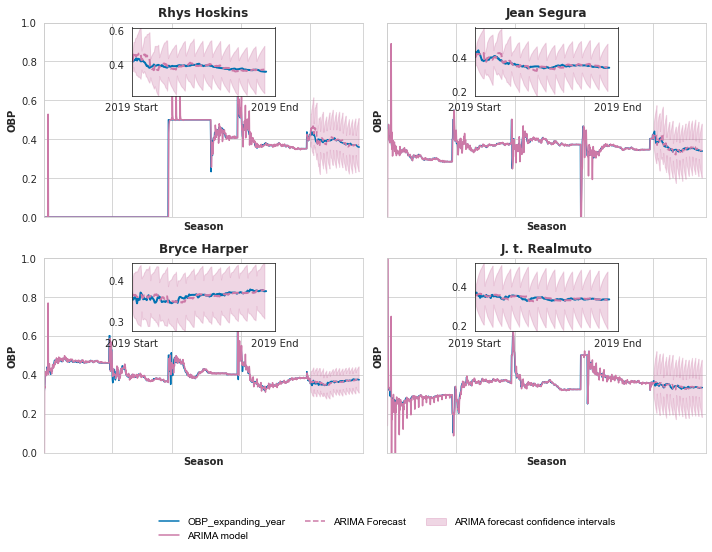

In [187]:
plot_train_test_arima(model_dict.Name.tolist(),model_dict,n_periods=10,endog_column="OBP_expanding_year",exog_column=exog_columns)

Now lets try it again but we will only predict 50 days out. Also just to see how the confidence is impacted, we will not correct our estimates with real data, but instead we will just use the predictions within future testing of our model.

Performing stepwise search to minimize aic


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=5.19 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-3187.273, Time=1.28 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-3301.434, Time=4.40 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=5.01 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-3187.792, Time=1.89 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-3439.416, Time=7.89 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=9.39 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.98 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-3441.959, Time=8.08 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-3301.411, Time=3.78 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=8.26 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=4.20 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-3441.145, Time=8.76 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-3424.765, Time=6.20 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=-3434.921, Time=7.80 sec

Best model:  ARIMA(0,1,0)(2,1,0)[12]          
Total fit time: 87.106 seconds
Performing stepwise search to minimize aic


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=4.54 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-2834.046, Time=0.72 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-3019.089, Time=4.33 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=4.46 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-2832.716, Time=1.47 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-3103.156, Time=9.42 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.49 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.41 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-3104.654, Time=7.24 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-3020.590, Time=3.50 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=7.87 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=4.02 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-3102.960, Time=7.82 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-3162.044, Time=9.65 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-3093.933, Time=4.79 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=inf, Time=9.17 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=5.38 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(2,1,0)[12]             : AIC=-3151.241, Time=9.83 sec
 ARIMA(1,1,2)(2,1,0)[12]             : AIC=-3169.770, Time=9.32 sec
 ARIMA(1,1,2)(1,1,0)[12]             : AIC=-3084.708, Time=5.19 sec
 ARIMA(1,1,2)(2,1,1)[12]             : AIC=-3311.040, Time=10.03 sec
 ARIMA(1,1,2)(1,1,1)[12]             : AIC=inf, Time=6.05 sec
 ARIMA(1,1,2)(2,1,2)[12]             : AIC=inf, Time=11.16 sec
 ARIMA(1,1,2)(1,1,2)[12]             : AIC=inf, Time=10.10 sec
 ARIMA(0,1,2)(2,1,1)[12]             : AIC=-3280.963, Time=9.48 sec
 ARIMA(2,1,2)(2,1,1)[12]             : AIC=-3326.776, Time=12.41 sec
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=5.77 sec
 ARIMA(2,1,2)(2,1,0)[12]             : AIC=-3181.058, Time=10.18 sec
 ARIMA(2,1,2)(2,1,2)[12]             : AIC=inf, Time=11.13 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=-3101.637, Time=5.20 sec
 ARIMA(2,1,2)(1,1,2)[12]             : AIC=inf, Time=10.17 sec
 ARIMA(2,1,1)(2,1,1)[12]             : AIC=-3279.314, Time=10.18 sec
 ARIMA(3

/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=4.70 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-3368.559, Time=0.84 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-3531.284, Time=4.36 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=4.71 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-3368.368, Time=0.40 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-3610.064, Time=7.88 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=9.27 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.34 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-3611.490, Time=7.52 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-3532.452, Time=3.87 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=7.41 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=4.07 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-3612.930, Time=8.26 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-3535.426, Time=3.84 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=8.39 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=4.51 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-3692.818, Time=8.31 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-3625.920, Time=4.40 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=inf, Time=8.81 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.74 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(2,1,0)[12]             : AIC=-3761.842, Time=10.16 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(1,1,0)[12]             : AIC=-3691.569, Time=5.72 sec
 ARIMA(2,1,1)(2,1,1)[12]             : AIC=-3883.857, Time=10.28 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=-3904.803, Time=4.95 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=inf, Time=4.94 sec
 ARIMA(2,1,1)(1,1,2)[12]             : AIC=inf, Time=10.56 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(0,1,0)[12]             : AIC=-3516.644, Time=2.41 sec
 ARIMA(2,1,1)(0,1,2)[12]             : AIC=inf, Time=8.96 sec
 ARIMA(2,1,1)(2,1,2)[12]             : AIC=inf, Time=11.14 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.69 sec
 ARIMA(3,1,1)(1,1,1)[12]             : AIC=inf, Time=5.58 sec
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=5.82 sec
 ARIMA(1,1,2)(1,1,1)[12]             : AIC=inf, Time=5.13 sec
 ARIMA(3,1,0)(1,1,1)[12]             : AIC=-3877.987, Time=5.04 sec
 ARIMA(3,1,2)(1,1,1)[12]             : AIC=inf, Time=5.68 sec
 ARIMA(2,1,1)(1,1,1)[12] intercept   : AIC=-3877.714, Time=6.24 sec

Best model:  ARIMA(2,1,1)(1,1,1)[12]          
Total fit time: 217.962 seconds
Performing stepwise search to minimize aic


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=5.09 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-3387.700, Time=0.70 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-3549.033, Time=5.39 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=3.99 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-3385.997, Time=0.63 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-3686.496, Time=8.65 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=9.41 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.53 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-3686.495, Time=7.89 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-3684.508, Time=9.46 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-3684.424, Time=9.73 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-3686.218, Time=8.17 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(2,1,0)[12]             : AIC=-3682.529, Time=10.73 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=-3684.311, Time=8.97 sec

Best model:  ARIMA(1,1,0)(2,1,0)[12]          
Total fit time: 93.325 seconds
Performing stepwise search to minimize aic


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=4.66 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-3100.556, Time=1.28 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-3291.838, Time=3.82 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=4.65 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-3105.634, Time=0.83 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-3372.409, Time=7.96 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.42 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.83 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-3369.947, Time=7.83 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-3536.609, Time=8.95 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-3453.599, Time=4.91 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=10.04 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=5.11 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-3541.049, Time=9.91 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=-3458.511, Time=5.03 sec
 ARIMA(3,1,0)(2,1,1)[12]             : AIC=inf, Time=10.19 sec
 ARIMA(3,1,0)(1,1,1)[12]             : AIC=inf, Time=5.53 sec
 ARIMA(4,1,0)(2,1,0)[12]             : AIC=-3584.448, Time=12.77 sec
 ARIMA(4,1,0)(1,1,0)[12]             : AIC=-3504.328, Time=6.04 sec
 ARIMA(4,1,0)

/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=4.49 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-3616.481, Time=0.75 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-3840.073, Time=4.31 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=5.80 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-3621.584, Time=0.88 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-3925.230, Time=8.59 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=9.64 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.60 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-3921.707, Time=7.15 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-3939.266, Time=9.05 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-3854.339, Time=4.97 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=10.95 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=5.66 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-3942.678, Time=7.49 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=-3855.649, Time=6.03 sec
 ARIMA(3,1,0)(2,1,1)[12]             : AIC=inf, Time=10.48 sec
 ARIMA(3,1,0)(1,1,1)[12]             : AIC=inf, Time=5.91 sec
 ARIMA(4,1,0)(2,1,0)[12]             : AIC=-3950.997, Time=13.50 sec
 ARIMA(4,1,0)(1,1,0)[12]             : AIC=-3860.661, Time=6.25 sec
 ARIMA(4,1,0)

/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=4.47 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-3187.581, Time=0.87 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-3430.969, Time=4.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=4.02 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-3197.011, Time=0.79 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-3519.959, Time=8.39 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.60 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.47 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-3510.073, Time=7.14 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-3517.983, Time=8.48 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-3517.969, Time=8.53 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-3519.614, Time=6.06 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(2,1,0)[12]             : AIC=-3515.999, Time=10.49 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=-3517.946, Time=8.16 sec

Best model:  ARIMA(1,1,0)(2,1,0)[12]          
Total fit time: 84.517 seconds
Performing stepwise search to minimize aic


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=4.63 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-3617.411, Time=0.71 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-3805.233, Time=4.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=4.19 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-3615.576, Time=0.50 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-3864.574, Time=7.90 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.35 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.34 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-3866.907, Time=7.66 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-3808.221, Time=3.70 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=7.62 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=4.15 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-3864.561, Time=7.66 sec


/Users/justinbrantley/miniconda3/envs/phillies-project-forecastML/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-3861.744, Time=8.13 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=-3864.188, Time=7.32 sec

Best model:  ARIMA(0,1,0)(2,1,0)[12]          
Total fit time: 80.940 seconds


/var/folders/mb/lkph6zw14x3fgj_tmmjpq0nr0000gn/T/ipykernel_96240/667869041.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


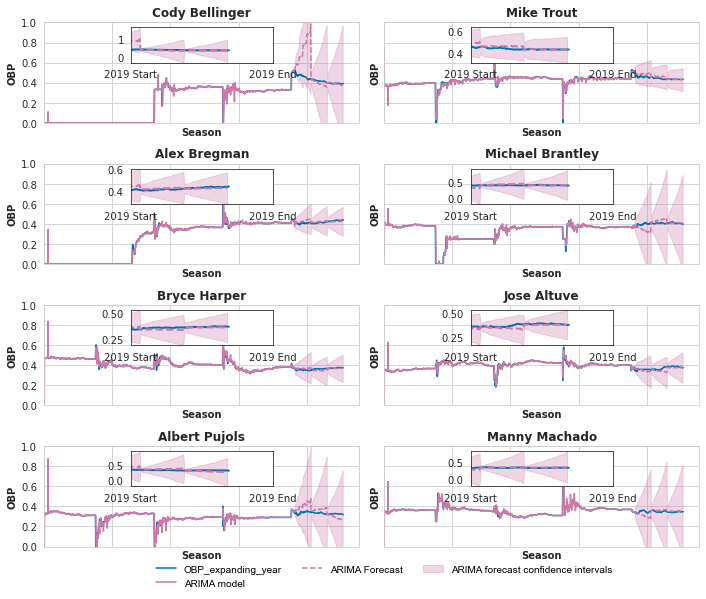

In [188]:
model_dict = train_test_arima(which_players,endog_column="OBP_expanding_year" ,exog_column=exog_columns,n_periods=50,update_with_true=True)
plot_train_test_arima(model_dict.Name.tolist(),model_dict,n_periods=50,endog_column="OBP_expanding_year",exog_column=exog_columns)